# Gait Phase Feature Analysis

This notebook analyzes the EMG features distribution across the 3 gait phase classes:
- **Stance** (Class 0)
- **Swing** (Class 1)
- **None** (Class 2)

It also visualizes feature evolution over the continuous gait cycle.

In [38]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Add src to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from lib.data_loader import Enabl3sDataLoader
from lib.preprocess import EMGPreprocessor
from lib.features import extract_statistical_features
from lib.dataset import MultiModeDataset

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

In [3]:
PHASE_NAMES = {
    0: "Stance",
    1: "Swing", 
    2: "None"
}

DYNAMIC_MODES = [1, 2, 3]
STATIC_MODES = [0, 6]

EMG_CHANNELS = ['TA', 'MG', 'RF']
LOAD_CHANNELS = ['TA', 'MG', 'RF', 'Mode', 'Ankle_Angle', 'Knee_Angle']
TARGET_FS = 250

In [32]:
def load_data(subject, data_root="../../data"):
    print(f"Loading {subject}...")
    loader = Enabl3sDataLoader(data_root, subject, target_fs=TARGET_FS)
    raw_dir = os.path.join(data_root, subject, 'Raw')
    
    circuit_files = [f for f in os.listdir(raw_dir) if f.endswith('_raw.csv')]
    circuits_to_load = range(1, len(circuit_files) + 1)
    
    df = loader.load_dataset_batch(circuits_to_load, LOAD_CHANNELS)
    
    if df.empty:
        return df
        
    # Filter modes
    df = df[df['Mode'].isin(DYNAMIC_MODES + STATIC_MODES)]
    
    # Preprocess
    preprocessor = EMGPreprocessor()
    df[EMG_CHANNELS] = preprocessor.apply_filter(df[EMG_CHANNELS].values)
    df[EMG_CHANNELS] = preprocessor.rectify(df[EMG_CHANNELS].values)
    
    # Add Class
    df['Phase_Class'] = 2
    is_dynamic = df['Mode'].isin(DYNAMIC_MODES)
    df.loc[is_dynamic & (df['Label_Phase'] == 1), 'Phase_Class'] = 0
    df.loc[is_dynamic & (df['Label_Phase'] == 0), 'Phase_Class'] = 1
    
    df['Phase_Name'] = df['Phase_Class'].map(PHASE_NAMES)
    
    return df

def extract_features_from_window(window, channels):
    """Extract MAV, RMS, and WL features from each EMG channel."""
    features = {}
    for i, ch in enumerate(channels):
        channel_data = window[:, i]
        features[f'{ch}_MAV'] = np.mean(np.abs(channel_data))
        features[f'{ch}_RMS'] = np.sqrt(np.mean(channel_data ** 2))
        features[f'{ch}_WL'] = np.sum(np.abs(np.diff(channel_data)))
    return features

def create_feature_dataset(df, emg_channels, window_size_ms, step_size_ms, target_fs):
    """Create windowed dataset and return a DataFrame with features."""
    dataset = MultiModeDataset(
        df=df,
        feature_cols=emg_channels,
        label_col='Mode',
        window_size_ms=window_size_ms,
        step_size_ms=step_size_ms,
        fs=target_fs
    )
    
    print(f"Extracting features from {len(dataset)} windows...")
    data_list = []
    
    for i, (window, label) in enumerate(dataset):
        feats = extract_features_from_window(window, emg_channels)
        feats['Mode'] = int(label)
        feats['Phase_Name'] = PHASE_NAMES.get(int(label), 'Unknown')
        data_list.append(feats)
        
    return pd.DataFrame(data_list)

In [5]:
# Load Data
df = load_data("AB156")
print(f"Loaded {len(df)} samples")
df.head()

21:15:07 - INFO - Starting batch load: Circuits 1 to 50...


Loading AB156...


21:15:08 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 57.07%
21:15:09 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 33.32%
21:15:09 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 33.05%
21:15:10 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 40.71%
21:15:10 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 26.70%
21:15:11 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 30.75%
21:15:11 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 33.10%
21:15:12 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 30.31%
21:15:12 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). Swing Ratio: 52.06%
21:15:13 - INFO - Labels generated via Processed Events (Heel Contact + Toe Off). 

Loaded 258973 samples


,TA,MG,RF,Ankle_Angle,Knee_Angle,Mode,Ankle_Norm,Circuit_ID,Label_Phase,Phase_Class,Phase_Name
0,0.058931,0.041151,0.038392,2.116808,3.090944,0.0,0.438050,1.0,0.0,2,None
1,0.028132,0.016556,0.023847,2.114977,3.092775,0.0,0.437992,1.0,0.0,2,None
2,0.025093,0.012851,0.013541,2.113756,3.092164,0.0,0.437953,1.0,0.0,2,None
3,0.052845,0.034950,0.025825,2.107652,3.093385,0.0,0.437760,1.0,0.0,2,None
4,0.011730,0.004949,0.003820,2.110704,3.095216,0.0,0.437857,1.0,0.0,2,None


## 1. Class Distribution

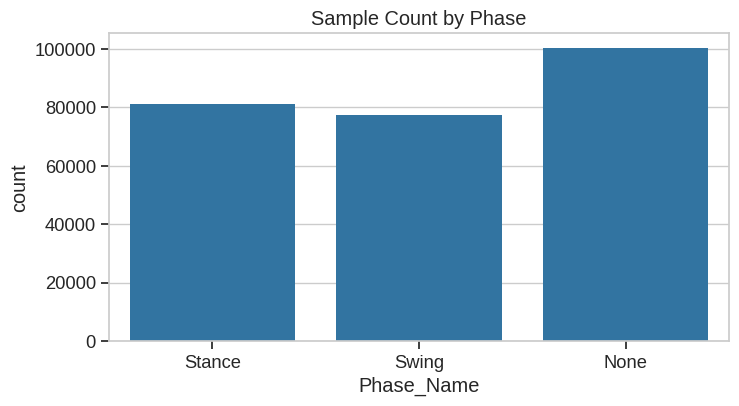

In [6]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Phase_Name', order=['Stance', 'Swing', 'None'])
plt.title("Sample Count by Phase")
plt.show()

## 2. Feature Distributions

In [35]:
feat_dataset = create_feature_dataset(df, EMG_CHANNELS, window_size_ms=2000, step_size_ms=100, target_fs=TARGET_FS)
feat_dataset.head()

Extracting features from 5154 windows...


,TA_MAV,TA_RMS,TA_WL,MG_MAV,MG_RMS,MG_WL,RF_MAV,RF_RMS,RF_WL,Mode,Phase_Name
0,0.021468,0.024051,9.030083,0.015440,0.018300,6.735107,0.008009,0.009100,3.204522,0,Stance
1,0.021429,0.023954,9.058609,0.015567,0.018345,6.696702,0.007922,0.008864,3.186098,0,Stance
2,0.021582,0.024069,9.024248,0.015649,0.018447,6.741866,0.007992,0.008910,3.175185,0,Stance
3,0.021474,0.023961,9.005354,0.015492,0.018322,6.675468,0.007942,0.008848,3.139767,0,Stance
4,0.021474,0.023993,9.101044,0.015343,0.018141,6.726878,0.007920,0.008823,3.120032,0,Stance


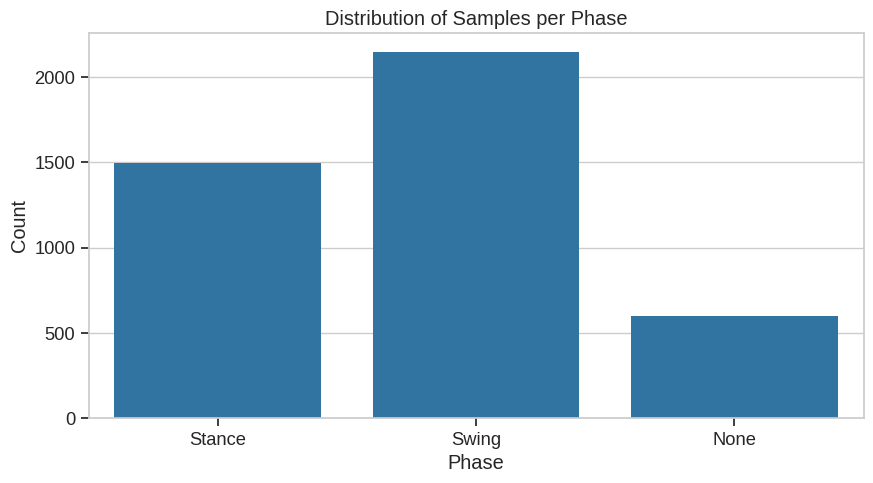

In [36]:
plt.figure(figsize=(10, 5))
sns.countplot(data=feat_dataset, x='Phase_Name', order=list(PHASE_NAMES.values()))
plt.title("Distribution of Samples per Phase")
plt.xlabel("Phase")
plt.ylabel("Count")
plt.show()

## 4. Feature Distributions by Class

Here we visualize the distribution of each feature (MAV, RMS, WL) for each Muscle (TA, MG, RF). Distinct distributions imply good separability.

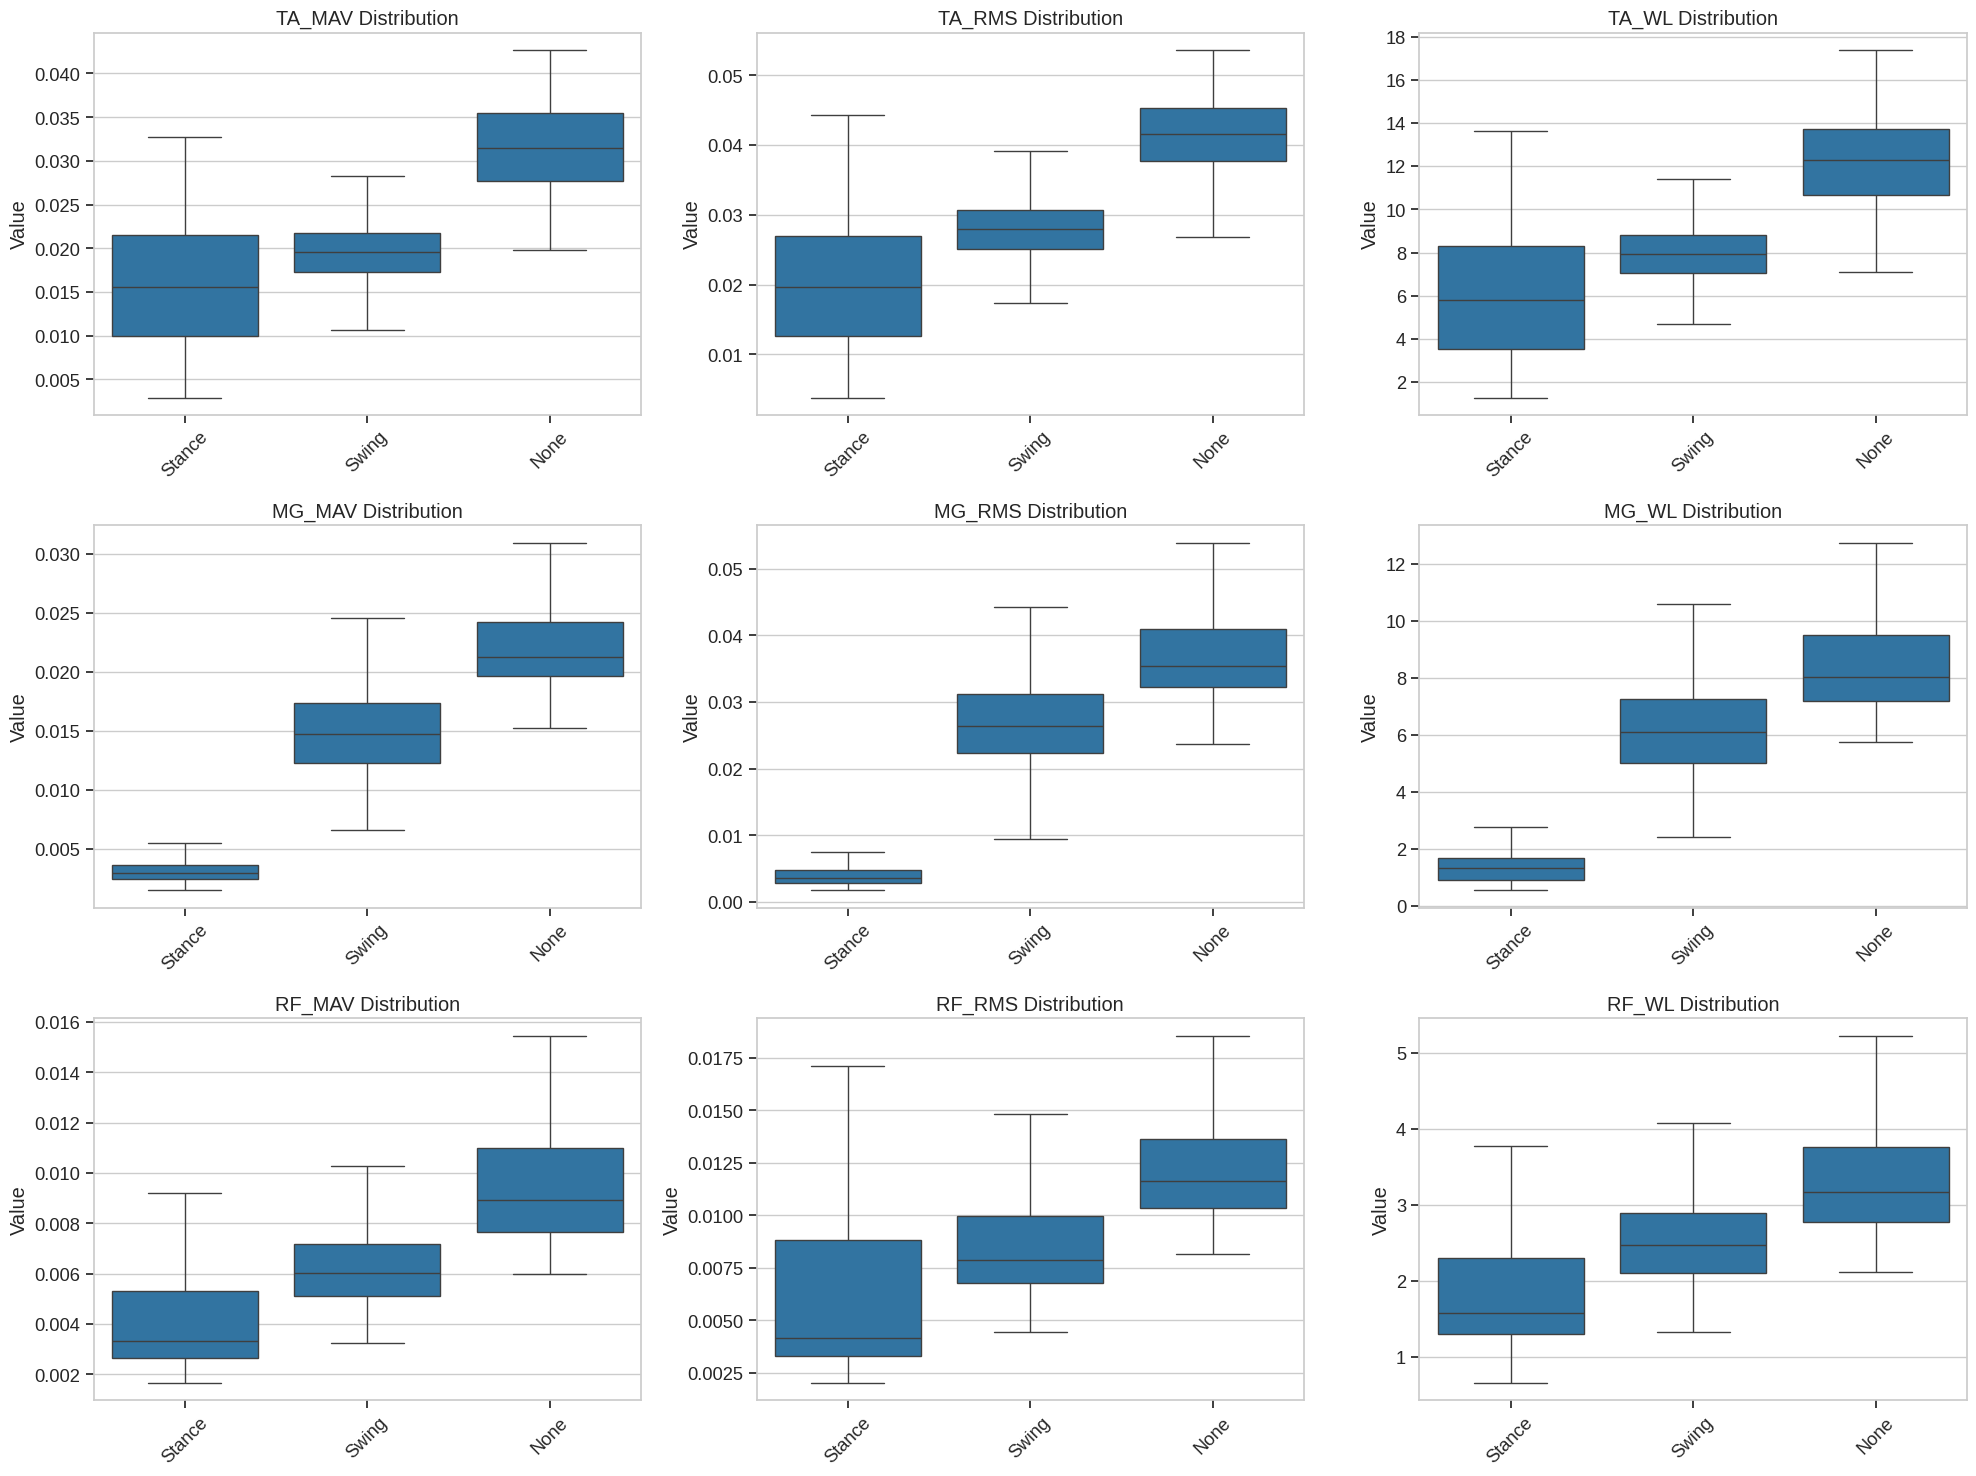

In [37]:
feature_cols = [c for c in feat_dataset.columns if c not in ['Mode', 'Phase_Name']]

plt.figure(figsize=(20, 15))
for i, col in enumerate(feature_cols):
    
    plt.subplot(3, 3, i + 1)
    sns.boxplot(data=feat_dataset, x='Phase_Name', y=col, showfliers=False, order=list(PHASE_NAMES.values()))
    plt.title(f"{col} Distribution")
    plt.xticks(rotation=45)
    plt.ylabel("Value")
    plt.xlabel("")
    
plt.tight_layout()
plt.show()

## 5. Dimensionality Reduction

We use PCA to project the 9-dimensional feature space (3 muscles * 3 features) into 2D to visualize global clusters.

In [44]:
feat_dataset.head()

,TA_MAV,TA_RMS,TA_WL,MG_MAV,MG_RMS,MG_WL,RF_MAV,RF_RMS,RF_WL,Mode,Phase_Name
0,0.021468,0.024051,9.030083,0.015440,0.018300,6.735107,0.008009,0.009100,3.204522,0,Stance
1,0.021429,0.023954,9.058609,0.015567,0.018345,6.696702,0.007922,0.008864,3.186098,0,Stance
2,0.021582,0.024069,9.024248,0.015649,0.018447,6.741866,0.007992,0.008910,3.175185,0,Stance
3,0.021474,0.023961,9.005354,0.015492,0.018322,6.675468,0.007942,0.008848,3.139767,0,Stance
4,0.021474,0.023993,9.101044,0.015343,0.018141,6.726878,0.007920,0.008823,3.120032,0,Stance


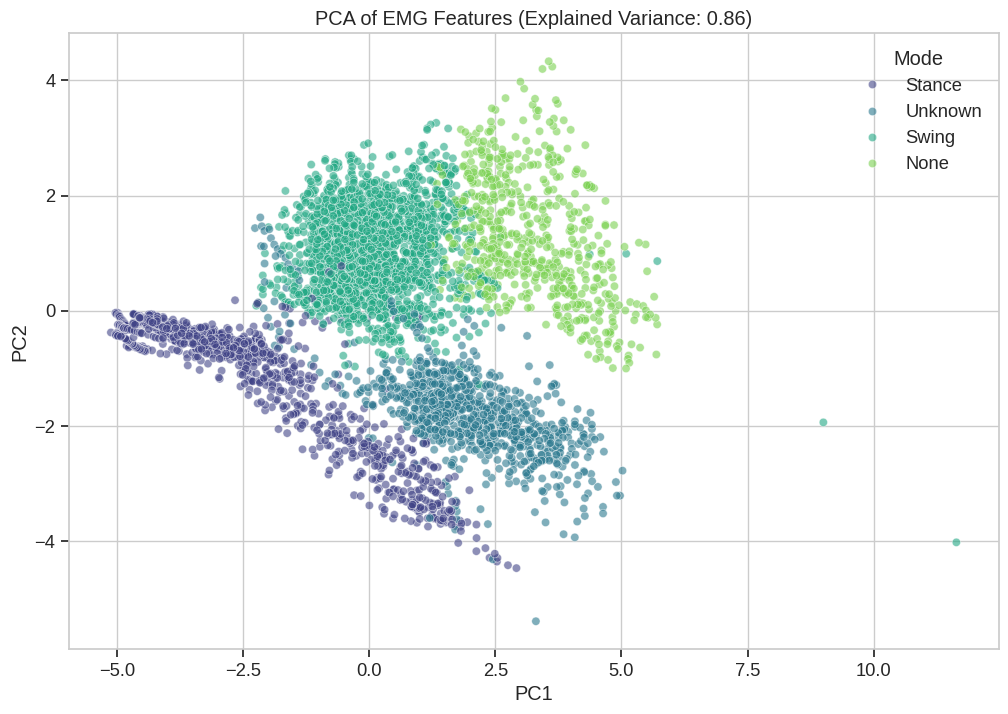

In [40]:
# Scale features
X = feat_dataset[feature_cols].values
y = feat_dataset['Phase_Name'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Mode'] = y

plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Mode', alpha=0.6, palette='viridis')
plt.title(f"PCA of EMG Features (Explained Variance: {pca.explained_variance_ratio_.sum():.2f})")
plt.show()